# NIR-Confocal Synchronization Example

This notebook demonstrates how to use the `sync_and_export.py` script to synchronize NIR camera data with confocal microscopy data.

`conda activate imgpro` or `conda activate g5ht-pipeline`

In [16]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tifffile as tif
import importlib

# Import the sync functions
from sync_and_export import (
    sync_nir_confocal,
    plot_timing_validation,
    export_aligned_data,
    run_full_pipeline
)
importlib.reload(sys.modules['sync_and_export'])  # Reload to get latest changes

<module 'sync_and_export' from 'c:\\Users\\munib\\POSTDOC\\CODE\\g5ht-pipeline\\nir\\sync_and_export.py'>

## 1. Quick Start: Run Complete Pipeline

The simplest way to process your data is to use the `run_full_pipeline` function, which performs all steps automatically.

NIR-CONFOCAL SYNCHRONIZATION PIPELINE
Loading data from: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001.h5
  Loading daqmx_ai (analog inputs)...
  Loading daqmx_di (digital inputs)...
  Loading img_metadata...
  Loading pos_stage...
  Getting img_nir shape...
  Data loaded successfully!
    - NIR images: (12927, 732, 968) (n_frames, height, width)
    - DAQ samples: 3
    - Metadata entries: 25854

Detecting confocal timing from piezo signal...
  Found 1200 peaks in piezo signal (confocal volumes/timepoints)


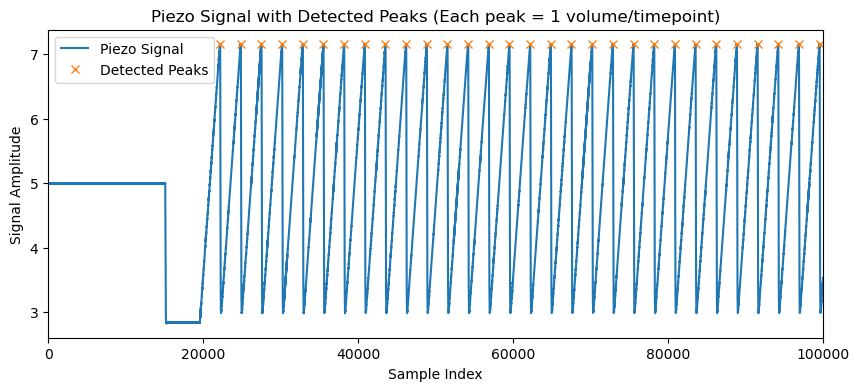

  Validating peak count against expected: 1200 volumes
  Peak spacing: mean=2667.3, std=4.4, range=[2651, 2696]

Detecting NIR timing from digital input...
  Found 26225 total NIR triggers
  Image IDs range: 0 to 26222
  Frames marked for save: 12927 / 25854
  Saved frame IDs range: 0 to 26221
  Filtered NIR starts: 12927

Creating NIR-to-confocal mapping...
  Created mapping for 1200 confocal volumes/timepoints
  NIR frame range: 84 to 12698

Generating validation plots...
  Saved validation plot: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_sync_validation_full.png

  Mapping statistics:
    Mean increment: 10.52
    Std increment: 0.52
    Non-unity mappings: 1199 / 1199
  Saved mapping plot: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001_sync_validation_full_mapping.png

Generating validation plots...
  Saved validation plot: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-

In [18]:
importlib.reload(sys.modules['sync_and_export'])  # Reload to get latest changes

# Set your data path
PTH = r'D:\DATA\g5ht-free\20251028'
FN = 'date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
h5_path = os.path.join(PTH, FN + '.h5')

# Expected number of confocal stacks (optional, for validation)
n_stacks = 1200

# Run the complete pipeline
output_files = run_full_pipeline(
    h5_path=h5_path,
    expected_n_volumes=n_stacks,
    output_dir=PTH,  # Will save outputs in same directory as h5 file
    min_peak_distance=100,  # Adjust if needed
    min_peak_prominence=1.0  # Adjust if needed
)

print("\nGenerated files:")
for key, path in output_files.items():
    print(f"  {key}: {path}")

## 2. Step-by-Step: Custom Processing

For more control, you can run each step separately.

### 2.1 Synchronize Timing

In [ ]:
# Run synchronization
confocal_peaks, nir_starts, mapping, data = sync_nir_confocal(
    h5_path=h5_path,
    expected_n_volumes=n_stacks,  # Fixed parameter name
    min_peak_distance=100,
    min_peak_prominence=1.0
)

print(f"\nSynchronization results:")
print(f"  Confocal volumes detected: {len(confocal_peaks)}")
print(f"  NIR frames (filtered): {len(nir_starts)}")
print(f"  Mapping length: {len(mapping)}")
print(f"  NIR frame range in mapping: {mapping.min()} to {mapping.max()}")

### 2.2 Generate Validation Plots

In [ ]:
# Full view
plot_timing_validation(
    confocal_peaks, nir_starts, mapping, data,
    output_path=os.path.join(PTH, f'{FN}_validation_full.png')
)

# Zoomed view (first 10000 samples)
plot_timing_validation(
    confocal_peaks, nir_starts, mapping, data,
    output_path=os.path.join(PTH, f'{FN}_validation_zoom.png'),
    plot_range=(0, 10000)
)

### 2.3 Export Aligned Data

In [ ]:
# Export NIR images, stage positions, and metadata
output_files = export_aligned_data(
    h5_path=h5_path,
    mapping=mapping,
    output_dir=PTH,
    save_nir=True,
    save_stage=True,
    save_metadata=True
)

print("\nExported files:")
for key, path in output_files.items():
    print(f"  {key}: {path}")

## 3. Inspect Results

### 3.1 Load and View Aligned NIR Images

In [ ]:
# Load aligned NIR images
nir_aligned = tif.imread(output_files['nir'])

print(f"Aligned NIR images shape: {nir_aligned.shape}")
print(f"  (n_stacks, height, width)")

# Display a few frames
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
frames_to_show = [0, len(nir_aligned)//3, 2*len(nir_aligned)//3, len(nir_aligned)-1]

for ax, frame_idx in zip(axes, frames_to_show):
    ax.imshow(nir_aligned[frame_idx], cmap='gray')
    ax.set_title(f'Frame {frame_idx}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 3.2 Load and View Stage Positions

In [ ]:
# Load aligned stage positions
stage_aligned = pd.read_csv(output_files['stage'], index_col=0)

print(f"Aligned stage positions shape: {stage_aligned.shape}")
print(f"\nFirst few entries:")
print(stage_aligned.head())

# Plot stage trajectory
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Position over time
ax = axes[0]
ax.plot(stage_aligned.index, stage_aligned['x'], 'o-', label='X position', markersize=3)
ax.plot(stage_aligned.index, stage_aligned['y'], 'o-', label='Y position', markersize=3)
ax.set_xlabel('Confocal Stack Index')
ax.set_ylabel('Position (μm)')
ax.set_title('Stage Position Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Trajectory in 2D
ax = axes[1]
scatter = ax.scatter(stage_aligned['x'], stage_aligned['y'], 
                     c=stage_aligned.index, cmap='viridis', s=50)
ax.plot(stage_aligned['x'], stage_aligned['y'], 'k-', alpha=0.3, linewidth=0.5)
ax.set_xlabel('X Position (μm)')
ax.set_ylabel('Y Position (μm)')
ax.set_title('Stage Trajectory (2D)')
ax.set_aspect('equal')
plt.colorbar(scatter, ax=ax, label='Confocal Stack')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Load and Inspect Metadata

In [ ]:
# Load synchronization metadata
metadata = np.load(output_files['metadata'])

print("Metadata contents:")
for key in metadata.files:
    print(f"  {key}: shape={metadata[key].shape}, dtype={metadata[key].dtype}")

# Access specific arrays
mapping_saved = metadata['mapping']
timestamps = metadata['timestamps']

print(f"\nMapping: {len(mapping_saved)} confocal stacks")
print(f"Timestamps range: {timestamps[0]:.2f}s to {timestamps[-1]:.2f}s")
print(f"Total duration: {timestamps[-1] - timestamps[0]:.2f}s")

## 4. Troubleshooting

If you encounter issues with peak detection, you can adjust the parameters:

In [ ]:
# Example: Test different peak detection parameters
from sync_and_export import detect_confocal_timing_peaks, load_h5_data

# Load data
data = load_h5_data(h5_path)
piezo_signal = data['daqmx_ai'][1, :]

# Try different parameters
test_params = [
    {'min_distance': 50, 'min_prominence': 0.5},
    {'min_distance': 100, 'min_prominence': 1.0},
    {'min_distance': 150, 'min_prominence': 1.5},
]

fig, axes = plt.subplots(len(test_params), 1, figsize=(14, 4*len(test_params)))

for ax, params in zip(axes, test_params):
    peaks = detect_confocal_timing_peaks(
        piezo_signal,
        expected_n_volumes=None,  # Fixed parameter name
        min_distance=params['min_distance'],
        min_prominence=params['min_prominence']
    )
    
    # Plot first 10000 samples
    x = np.arange(10000)
    ax.plot(x, piezo_signal[:10000], 'b-', linewidth=0.5)
    peaks_in_range = peaks[peaks < 10000]
    ax.plot(peaks_in_range, piezo_signal[peaks_in_range], 'r*', markersize=10)
    ax.set_title(f"Distance={params['min_distance']}, Prominence={params['min_prominence']}: "
                f"{len(peaks)} peaks found")
    ax.set_ylabel('Piezo Signal')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Sample Index')
plt.tight_layout()
plt.show()

## 5. Command Line Usage

You can also run the script from the command line:

```bash
python sync_and_export.py \
    --h5_path "D:\DATA\g5ht-free\20251223\date-20251223_strain-ISg5HT_condition-starvedpatch_worm005.h5" \
    --expected_n_volumes 1200 \
    --output_dir "D:\DATA\g5ht-free\20251223" \
    --min_peak_distance 100 \
    --min_peak_prominence 1.0
```

**Note:** `expected_n_volumes` should be the number of timepoints/volumes (e.g., 1200), NOT the number of z-slices per volume (e.g., 41).